# T-SNE visualization with VGG feature extraction of CIFAR-10

## Dependencies
* numpy
* tensorflow
* keras
* keras_vggface
* scikit-learn
* matplotlib
* glob
* PIL

### CIFAR-10 data visualization with T-SNE
The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. 
<br>
As its very compute intesive to use all the data so choosen 1000 images at random from the data set. This image dataset is subset of the CIFAR-10 data set. Chosen this particular data set to get a large number of lower resolution image data. This is a very good example of 10 different categories of data. This data set doesn't have any labels so analyzing the 1000 images manually is tedious with such low resolution images hence would be perfect choice to apply SOM techniques like T-SNE to get the pattern in data that to in visualized form.
<br>
<br>
It takes about 50 minutes for feature extraction and T-SNE(t-Distributed Stochastic Neighbor Embedding) run with 1000 images. 
(Approx time on Intel i7 3.2GHz with 16 GB RAM )

#### The 32x32 images are of have the following classes
* plane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


#### The images can be obtained from:
http://www.cs.toronto.edu/~kriz/cifar.html or https://www.kaggle.com/c/cifar-10/data


### VGG feature extraction model:
VGG model is pre-trained on ImageNet.
The convolutional layer parameters are denoted as "conv⟨receptive field size⟩-⟨number of channels⟩
They're powerful and transferable, interpretable.
Mot importantly they have shown excellent results.
<br>
Hence choose this model for feature extraction. 

In [13]:
from time import time
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import os, re, glob, pickle

In [14]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
# custom paramers: change these parameters to properly run on your machine
image_path = 'samp/' # addres of images

#### Path of the foolder where images have been saved on the system
* "samp/" folder ( relative path to the jupyter notebook)

In [16]:
no_of_images = 1000 # number of images. It is recommended to use a square of 2 number

#### no_of_images: Can change this parameter to run with less number of images

In [17]:
ellipside =True # elipsoid or rectangular visualization

#### elipsoid or rectangular visualization
* Using ellipside visualization gives better understanding of the overall indivisual clusters 
* Whereas with rectangular, we get a more space optimized & merged image 

In [18]:
image_width = 64 # width and height of each visualized images

In [19]:
feature_extraction = 'vggfaces' # feature extraction method

#### Choosing the feature extraction method
* The features have been extracted using a inception model. 
* We load the data from the samp/ folder with initial seed of 1000 images
* Will be plotting the final image in Ellipside format instead of rectangular flat.

In [20]:
# find all images
image_names  = glob.glob(image_path + "*.png") 
image_names +=glob.glob(image_path + "*.jpg")
image_names +=glob.glob(image_path + "*.gif")


* Using glob to gather all the image name 

In [21]:
# Let's display the internal variables to make sure all the images are getting processed properly
print(image_names)
print(image_path)

['samp\\1.png', 'samp\\10.png', 'samp\\100.png', 'samp\\1000.png', 'samp\\101.png', 'samp\\102.png', 'samp\\103.png', 'samp\\104.png', 'samp\\105.png', 'samp\\106.png', 'samp\\107.png', 'samp\\108.png', 'samp\\109.png', 'samp\\11.png', 'samp\\110.png', 'samp\\111.png', 'samp\\112.png', 'samp\\113.png', 'samp\\114.png', 'samp\\115.png', 'samp\\116.png', 'samp\\117.png', 'samp\\118.png', 'samp\\119.png', 'samp\\12.png', 'samp\\120.png', 'samp\\121.png', 'samp\\122.png', 'samp\\123.png', 'samp\\124.png', 'samp\\125.png', 'samp\\126.png', 'samp\\127.png', 'samp\\128.png', 'samp\\129.png', 'samp\\13.png', 'samp\\130.png', 'samp\\131.png', 'samp\\132.png', 'samp\\133.png', 'samp\\134.png', 'samp\\135.png', 'samp\\136.png', 'samp\\137.png', 'samp\\138.png', 'samp\\139.png', 'samp\\14.png', 'samp\\140.png', 'samp\\141.png', 'samp\\142.png', 'samp\\143.png', 'samp\\144.png', 'samp\\145.png', 'samp\\146.png', 'samp\\147.png', 'samp\\148.png', 'samp\\149.png', 'samp\\15.png', 'samp\\150.png', 'sa

In [22]:
# suffle images
np.random.seed(3)
np.random.shuffle(image_names)

* Modifing the sequence in-place by shuffling the contents to avoid any bias.

In [23]:
if no_of_images > len(image_names):
    no_of_images = len(image_names)
image_names = image_names[:no_of_images]

* Checking if the no_of_images is set higher than actual number of images in the folder

In [24]:
t0 = time()

# vgg
if feature_extraction == 'vggfaces':
    print('using %s network/method for feature extraction'%feature_extraction)
    # Convolution Features
    features = np.zeros([no_of_images, 2048])
    vgg_model_conv = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    # FC7 Features
    vgg_model = VGGFace() # pooling: None, avg or max
    out = vgg_model.get_layer('fc7').output
    vgg_model_fc7 = Model(vgg_model.input, out)

    feature_filename = '%s-feature-vggfaces-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 4096])
        for i, name in enumerate(image_names):
            img = image.load_img(name, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x)
            print('image name: %s progress: %d/%d'%(name, i, no_of_images))
            features[i, :] = vgg_model_fc7.predict(x)
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)
            

t1 = time()
print("VGG Feature extraction time  %.2g sec" % (t1 - t0))

using vggfaces network/method for feature extraction
image name: samp\677.png progress: 0/1000
image name: samp\785.png progress: 1/1000
image name: samp\917.png progress: 2/1000
image name: samp\278.png progress: 3/1000
image name: samp\626.png progress: 4/1000
image name: samp\816.png progress: 5/1000
image name: samp\686.png progress: 6/1000
image name: samp\779.png progress: 7/1000
image name: samp\473.png progress: 8/1000
image name: samp\547.png progress: 9/1000
image name: samp\561.png progress: 10/1000
image name: samp\509.png progress: 11/1000
image name: samp\892.png progress: 12/1000
image name: samp\576.png progress: 13/1000
image name: samp\260.png progress: 14/1000
image name: samp\502.png progress: 15/1000
image name: samp\776.png progress: 16/1000
image name: samp\827.png progress: 17/1000
image name: samp\338.png progress: 18/1000
image name: samp\150.png progress: 19/1000
image name: samp\32.png progress: 20/1000
image name: samp\213.png progress: 21/1000
image name: 

image name: samp\52.png progress: 188/1000
image name: samp\568.png progress: 189/1000
image name: samp\372.png progress: 190/1000
image name: samp\748.png progress: 191/1000
image name: samp\399.png progress: 192/1000
image name: samp\36.png progress: 193/1000
image name: samp\572.png progress: 194/1000
image name: samp\246.png progress: 195/1000
image name: samp\802.png progress: 196/1000
image name: samp\616.png progress: 197/1000
image name: samp\992.png progress: 198/1000
image name: samp\740.png progress: 199/1000
image name: samp\169.png progress: 200/1000
image name: samp\197.png progress: 201/1000
image name: samp\28.png progress: 202/1000
image name: samp\517.png progress: 203/1000
image name: samp\227.png progress: 204/1000
image name: samp\913.png progress: 205/1000
image name: samp\284.png progress: 206/1000
image name: samp\335.png progress: 207/1000
image name: samp\396.png progress: 208/1000
image name: samp\190.png progress: 209/1000
image name: samp\793.png progress: 

image name: samp\902.png progress: 375/1000
image name: samp\800.png progress: 376/1000
image name: samp\265.png progress: 377/1000
image name: samp\137.png progress: 378/1000
image name: samp\441.png progress: 379/1000
image name: samp\631.png progress: 380/1000
image name: samp\635.png progress: 381/1000
image name: samp\226.png progress: 382/1000
image name: samp\983.png progress: 383/1000
image name: samp\604.png progress: 384/1000
image name: samp\807.png progress: 385/1000
image name: samp\415.png progress: 386/1000
image name: samp\384.png progress: 387/1000
image name: samp\389.png progress: 388/1000
image name: samp\799.png progress: 389/1000
image name: samp\526.png progress: 390/1000
image name: samp\791.png progress: 391/1000
image name: samp\762.png progress: 392/1000
image name: samp\395.png progress: 393/1000
image name: samp\944.png progress: 394/1000
image name: samp\233.png progress: 395/1000
image name: samp\632.png progress: 396/1000
image name: samp\159.png progres

image name: samp\426.png progress: 562/1000
image name: samp\511.png progress: 563/1000
image name: samp\192.png progress: 564/1000
image name: samp\34.png progress: 565/1000
image name: samp\866.png progress: 566/1000
image name: samp\702.png progress: 567/1000
image name: samp\315.png progress: 568/1000
image name: samp\486.png progress: 569/1000
image name: samp\882.png progress: 570/1000
image name: samp\281.png progress: 571/1000
image name: samp\936.png progress: 572/1000
image name: samp\185.png progress: 573/1000
image name: samp\519.png progress: 574/1000
image name: samp\713.png progress: 575/1000
image name: samp\541.png progress: 576/1000
image name: samp\248.png progress: 577/1000
image name: samp\943.png progress: 578/1000
image name: samp\838.png progress: 579/1000
image name: samp\382.png progress: 580/1000
image name: samp\423.png progress: 581/1000
image name: samp\222.png progress: 582/1000
image name: samp\347.png progress: 583/1000
image name: samp\444.png progress

image name: samp\301.png progress: 749/1000
image name: samp\715.png progress: 750/1000
image name: samp\183.png progress: 751/1000
image name: samp\298.png progress: 752/1000
image name: samp\636.png progress: 753/1000
image name: samp\728.png progress: 754/1000
image name: samp\524.png progress: 755/1000
image name: samp\979.png progress: 756/1000
image name: samp\64.png progress: 757/1000
image name: samp\885.png progress: 758/1000
image name: samp\129.png progress: 759/1000
image name: samp\294.png progress: 760/1000
image name: samp\163.png progress: 761/1000
image name: samp\297.png progress: 762/1000
image name: samp\290.png progress: 763/1000
image name: samp\873.png progress: 764/1000
image name: samp\453.png progress: 765/1000
image name: samp\966.png progress: 766/1000
image name: samp\429.png progress: 767/1000
image name: samp\109.png progress: 768/1000
image name: samp\925.png progress: 769/1000
image name: samp\407.png progress: 770/1000
image name: samp\277.png progress

image name: samp\433.png progress: 936/1000
image name: samp\345.png progress: 937/1000
image name: samp\732.png progress: 938/1000
image name: samp\1.png progress: 939/1000
image name: samp\608.png progress: 940/1000
image name: samp\898.png progress: 941/1000
image name: samp\585.png progress: 942/1000
image name: samp\549.png progress: 943/1000
image name: samp\745.png progress: 944/1000
image name: samp\443.png progress: 945/1000
image name: samp\463.png progress: 946/1000
image name: samp\603.png progress: 947/1000
image name: samp\875.png progress: 948/1000
image name: samp\116.png progress: 949/1000
image name: samp\823.png progress: 950/1000
image name: samp\257.png progress: 951/1000
image name: samp\40.png progress: 952/1000
image name: samp\44.png progress: 953/1000
image name: samp\59.png progress: 954/1000
image name: samp\252.png progress: 955/1000
image name: samp\566.png progress: 956/1000
image name: samp\846.png progress: 957/1000
image name: samp\555.png progress: 95

In [25]:
# use tsne to cluster images in 2 dimensions
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

* After getting the feature we now are applying T-SNE to reduce the dimensions of the system to get a better visualization.
<br> 
* t-SNE reduces the dimensionality of each point, the points in the lower-dimensional space preserve the pointwise distances from the original, higher-dimensional space in this case the similar images will be clustered together.

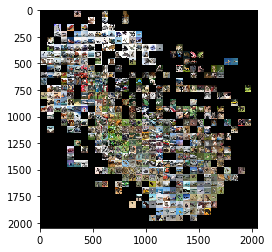

In [26]:
# draw all images in a merged image
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()
merged_image = Image.fromarray(merged_image)
if ellipside:
    if feature_extraction == 'inception':
        merged_image.save('merged-%s-ellipsoide-inception.png'%image_path.split('/')[-2])
    elif feature_extraction == 'raw':
        merged_image.save('merged-%s-ellipsoide-raw.png'%image_path.split('/')[-2])
    else:
        merged_image.save('merged-%s-ellipsoide-vgg.png'%image_path.split('/')[-2])
else:
    merged_image.save('merged-%s.png'%image_path.split('/')[-2])
    if feature_extraction == 'inception':
        merged_image.save('merged-%s-inception.png'%image_path.split('/')[-2])
    elif feature_extraction == 'raw':
        merged_image.save('merged-%s-raw.png'%image_path.split('/')[-2])
    else:
        merged_image.save('merged-%s-vgg.png'%image_path.split('/')[-2])

### T-SNE visulaization of the data 

#### Better ..... Does a decent job
* If we look more close to the image by zooming in or check the saved image, we can clearly see that most of the data has been categorized in smaller clusters though not perfectly.
<br>
* First on top left corner we can see that most of the automobiles/cars are clustered together. But some animal images have managed to creep in.
* It does a good job with the horses on the left middle of the image where a small cluster has been formed. Then on the upper right side, most trucks are combined together. Similarly the planes on the bottom right side. 
<br>
* The frogs and dogs are clusters in the middle towards left side.
 <br>

<br>
* Also the boundary between dogs & cats is not distinct or those clusters are not far away from each other as most of the pics of dogs (puppies) and of cats are similar in a way of their appearance like color and structure. As these are just 32x32 images hence a clear differentiation between these two wont established easily.
<br>
<br>
* The images of ships are kind of perfectly clustered on right bottom but was not able to differentiate between ship & plane because of similar blue background color. 


### Reference :
* https://arxiv.org/abs/1512.00567
* https://github.com/tensorflow/models/tree/master/research/inception
* https://www.tensorflow.org/tutorials/image_recognition
* http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
